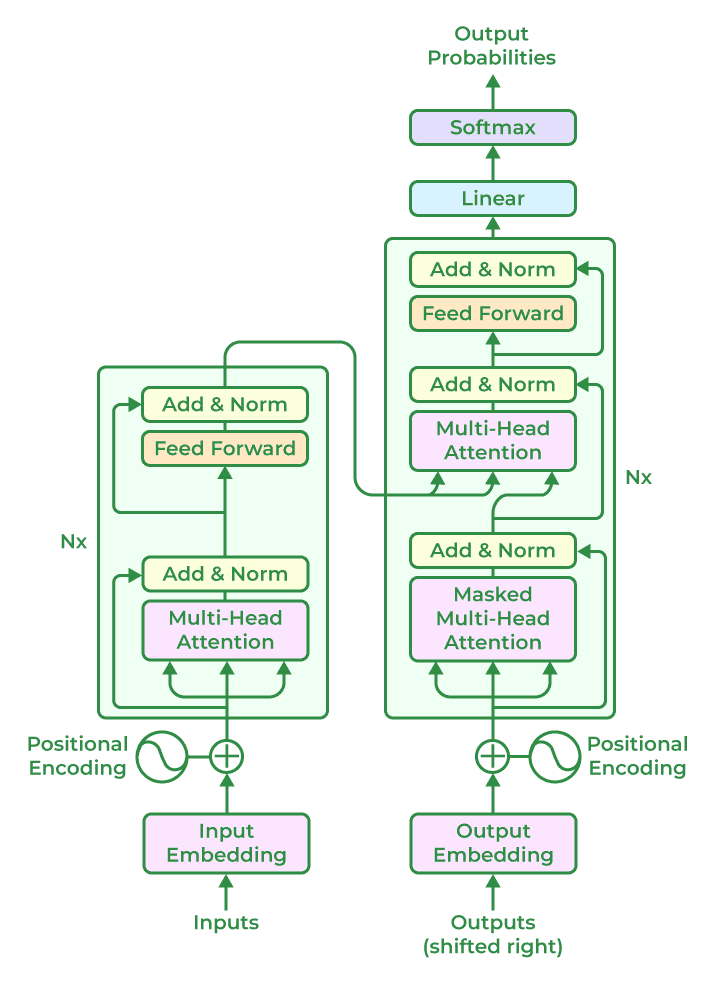

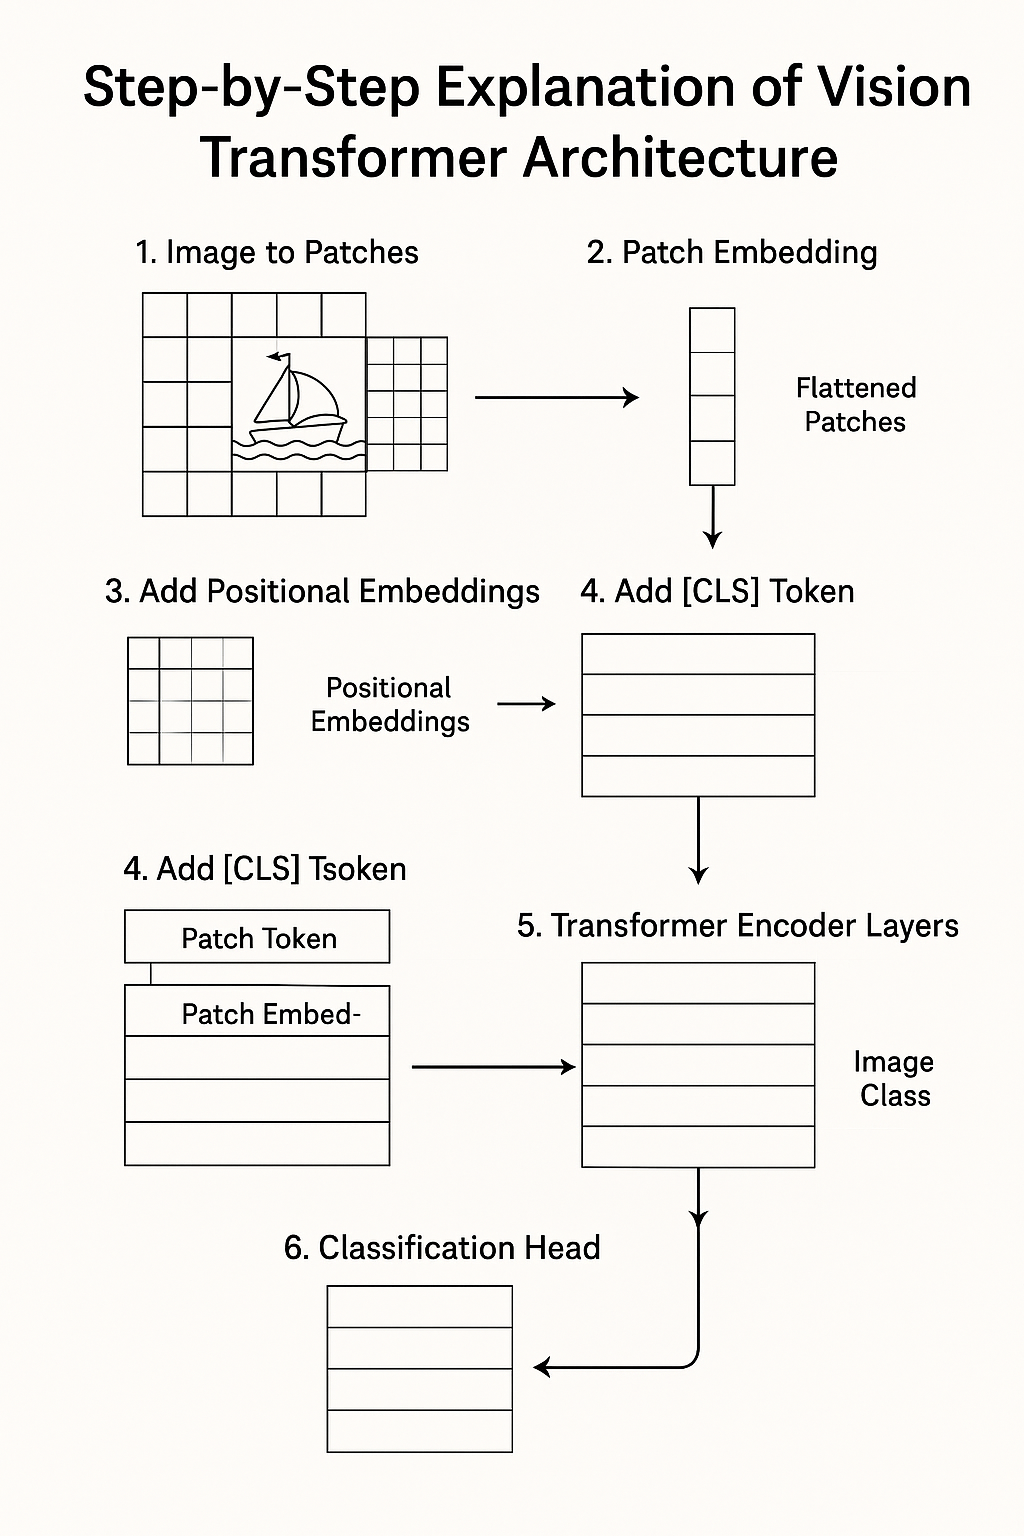

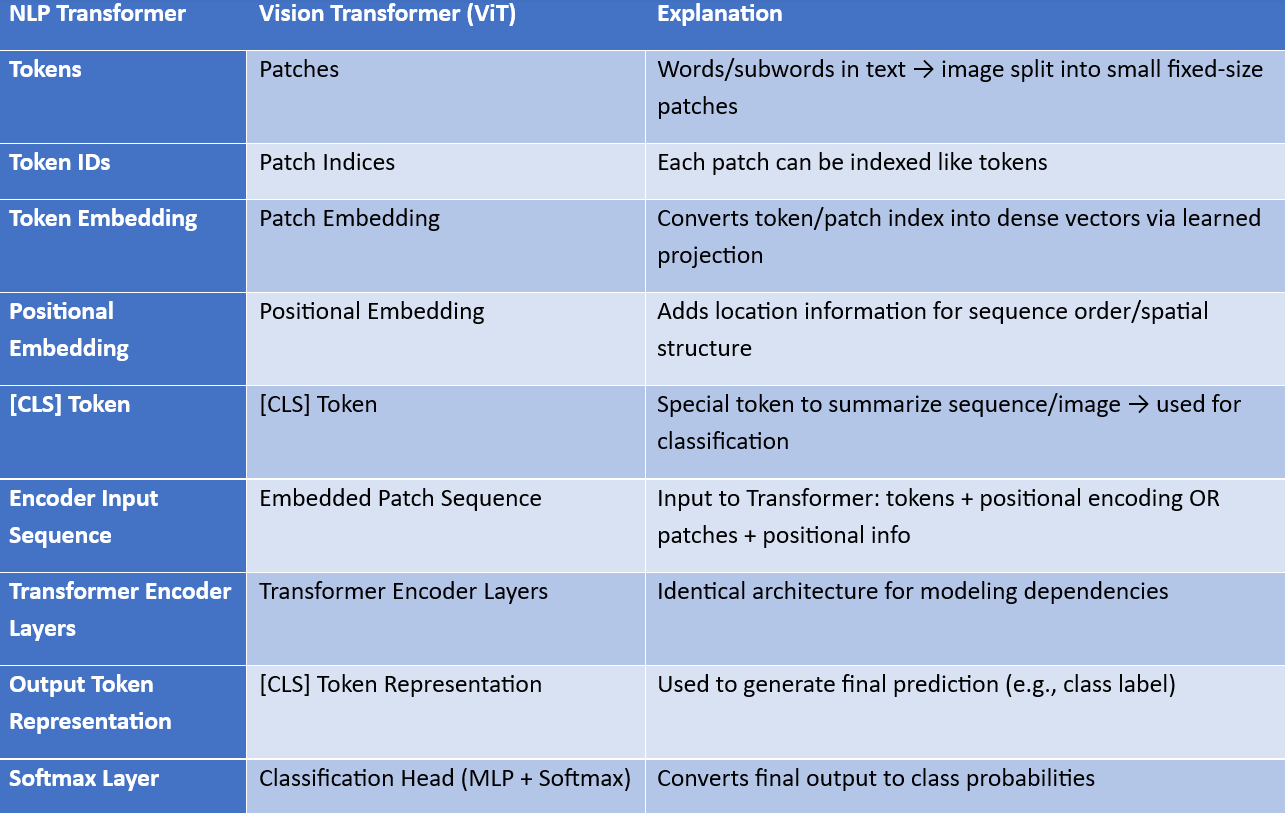

Step-by-Step Vision Transformer (ViT) Pipeline
Image to Patches

* The input image (e.g., 224×224×3) is divided into fixed-size patches (e.g., 16×16).

* This converts the image into a sequence of small flattened grids.

* Patch Embedding

* Each patch is flattened into a vector and passed through a linear projection layer to embed it into a fixed-length vector (like word embeddings in NLP).

* Add Positional Embeddings

* Since Transformers have no built-in sense of order, positional embeddings are added to each patch embedding to preserve spatial information.

* Add [CLS] Token

* A special learnable token [CLS] is prepended to the sequence. Its output after the Transformer will represent the whole image (used for classification).

* Transformer Encoder Layers

* The sequence (patch embeddings + CLS + positional encoding) is fed into standard Transformer encoder layers:

* Multi-Head Self-Attention

* Add & Norm

* Feed Forward Network

* Add & Norm

* Classification Head

* The final hidden state of the [CLS] token is passed through a classification layer (typically an MLP) to produce the predicted image class.

# Import required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
torch.__version__

In [ ]:
torchvision.__version__

## 2. Setup Device-Agnostic Code

In [ ]:
!nvidia-smi

In [ ]:
torch.cuda.is_available()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
print(f"Using Device: {device}")

## 3. Set the seed

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

## 4. Setting the hyperprameters

In [ ]:
3e-4

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10 # Try increasing epochs to 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32 # Transform the image and make the size go to 224
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8 # INcrease the number heads
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

## 5. Define Image Transformations

In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
#     # 1. Helps the model to converge faster
#     # 2. Helps to make the numerical computations stable
# ])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

## 6. Getting a dataset

In [ ]:
train_dataset = datasets.CIFAR10(root="data",
                                 train=True,
                                 download=True,
                                 transform=transform)

In [ ]:
test_dataset = datasets.CIFAR10(root="data",
                                train=False,
                                download=True,
                                transform=transform)

In [ ]:
train_dataset

In [ ]:
test_dataset

In [ ]:
len(train_dataset)

In [ ]:
len(test_dataset)

## 7. Converting our datasets into dataloaders

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our data into batches or (mini-batches)

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memroy) at 50000 images in one hit. So we break it into 128 images at a time. (batch size of 128).
2. It gives our neural network more chances to update its gradients per epoch

In [ ]:
BATCH_SIZE

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

In [ ]:
# Let's check out what we've created
print(f"DataLoader: {train_loader, test_loader}")
print(f"Length of train_loader: {len(train_loader)} batches of {BATCH_SIZE}...")
print(f"Length of test_loader: {len(test_loader)} batches of {BATCH_SIZE}...")

In [ ]:
128 * 390.625

In [ ]:
50000 / 128

## 8. Building Vision Transformer Model From Scratch

In [ ]:
PATCH_SIZE

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 img_size,
                 patch_size,
                 in_channels,
                 embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels=in_channels,
                              out_channels=embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x: torch.Tensor):
        B = x.size(0)
        x = self.proj(x) # (B, E, H/P, W/P)
        x = x.flatten(2).transpose(1, 2) # (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x

In [ ]:
F

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0]
        return self.head(cls_token)

In [ ]:
DEPTH

In [ ]:
device

In [ ]:
# Instantiate model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device)

In [ ]:
model

## 9. Defining a Loss function and an optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE)

In [ ]:
criterion

In [ ]:
optimizer

## 10. Defining a Training Loop function

In [ ]:
device

In [ ]:
def train(model, loader, optimizer, criterion):
    # Set the mode of the model into training
    model.train()

    total_loss, correct = 0, 0

    for x, y in loader:
        # Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # 1. Forward pass (model outputs raw logits)
        out = model(x)
        # 2. Calcualte loss (per batch)
        loss = criterion(out, y)
        # 3. Perform backpropgation
        loss.backward()
        # 4. Perforam Gradient Descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    # You have to scale the loss (Normlization step to make the loss general across all batches)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [ ]:
def evaluate(model, loader):
    model.eval() # Set the mode of the model into evlauation
    correct = 0
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
EPOCHS

In [ ]:
from tqdm.auto import tqdm

In [ ]:
### Training
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")

In [ ]:
train_accuracies

In [ ]:
test_accuracies

In [ ]:
# Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [ ]:
import random

In [ ]:
len(test_dataset)

In [ ]:
test_dataset[0][0].unsqueeze(dim=0).shape

In [ ]:
test_dataset[0][0] / 2 + 0.5

In [ ]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()